<a href="https://colab.research.google.com/github/Mena-E/Power-model/blob/master/CCCP_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Building a Model to Predict Electrical Power Output of a Combined Cycle Power Plant.

### Introduction

Curbing the rate of climate change would require a combination of putting more renewable energy sources online and drastically reducing our consumption of fossil fuels. Electrical energy consumption is one area where human behavior could have a big impact on climate change. One area in particular where consumption is likely to increase is in automobiles as the world transistions from fossil fuel driven vehicles to electrical vehicles. Operation of Combined Cycle Power plants is one way The Electrical Energy Industry provides electrical power efficiently while reducing pollution via consumption of less natural gas per megawatt of energy produced. The goal of this project is to predict Electrical Power Energy Output (PE) from a combined Cycle Power Plant using four variables:

1. AT - Ambient Temperature (Degrees Celsius)
2. AP - Ambient Pressure (Millibar)
3. RH - Realtive Humidity (%)
4. V - Exhaust Vacuum from the compressor (cm Hg)


- The prediction will be done with Regression Model. 
- To check the metrics of the models, I will be using the following:

 - Root Mean Square Error (RMSE)
 - Mean Absolute Error (MAE), and 
 - R-Square 

### Combined Cycle Power Plant - A Brief Description


 For an explanation of how a Combined Cycle Power Plant works, click on this link 
[GE](https://www.ge.com/power/resources/knowledge-base/combined-cycle-power-plant-how-it-works)

In [ ]:
%%capture
import sys

!pip install pdpbox
!pip install shap

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from numpy.random import permutation
from sklearn.inspection import permutation_importance
from pdpbox.pdp import pdp_isolate, pdp_plot
from pdpbox.pdp import pdp_interact, pdp_interact_plot
from shap import TreeExplainer, initjs, force_plot
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import SelectKBest
from sklearn.pipeline import make_pipeline
plt.rcParams['figure.dpi'] = 72

In [ ]:
DATA_PATH = '/content/drive/MyDrive/combine_cycle.csv'

In [ ]:
def wrangle(filepath):
  df = pd.read_csv(filepath, index_col=[0])

  return df

In [ ]:
df = wrangle(DATA_PATH)
df.head()

,AT,V,AP,RH,PE
0,14.96,41.76,1024.07,73.17,463.26
1,25.18,62.96,1020.04,59.08,444.37
2,5.11,39.40,1012.16,92.14,488.56
3,20.86,57.32,1010.24,76.64,446.48
4,10.82,37.50,1009.23,96.62,473.90


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9568 entries, 0 to 9567
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AT      9568 non-null   float64
 1   V       9568 non-null   float64
 2   AP      9568 non-null   float64
 3   RH      9568 non-null   float64
 4   PE      9568 non-null   float64
dtypes: float64(5)
memory usage: 448.5 KB


In [ ]:
df.describe()

,AT,V,AP,RH,PE
count,9568.000000,9568.000000,9568.000000,9568.000000,9568.000000
mean,19.651231,54.305804,1013.259078,73.308978,454.365009
std,7.452473,12.707893,5.938784,14.600269,17.066995
min,1.810000,25.360000,992.890000,25.560000,420.260000
25%,13.510000,41.740000,1009.100000,63.327500,439.750000
50%,20.345000,52.080000,1012.940000,74.975000,451.550000
75%,25.720000,66.540000,1017.260000,84.830000,468.430000
max,37.110000,81.560000,1033.300000,100.160000,495.760000


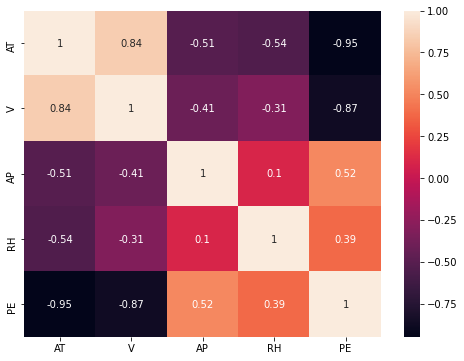

In [ ]:
# Use a seaborn heatmap to check correlations between the features and the target
plt.figure(figsize=(8,6))
sns.heatmap(df.corr(), annot=True);

#### Distribution of Target Variable (PE)
> The target variable is the net hourly average of electrical energy output measured in Megawatts (MW)

In [ ]:
target_hist = px.histogram(df, x='PE')
target_hist.show();

#### Plot of target variable against individual features
> Target varibale (EP) against the Ambient Temperature (AT) measured in Degrees Celsius.

In [ ]:
# EP V AT
fig1 = px.scatter(df, x='AT', y='PE', trendline='ols',
                  title="Plot of Energy Output (EP) against Ambient Temperature (AT)")
fig1.show();

In [ ]:
# PE V RH
fig2 = px.scatter(df, x='RH', y='PE', trendline='ols',
                   title="Plot of Energy Output (EP) against Relative Humidity (RH)")
fig2.show();

In [ ]:
# PE V AP
fig3 = px.scatter(df, x='AP', y='PE', trendline='ols',
                   title="Plot of Energy Output (EP) against Ambient Pressure (Ap)")
fig3.show();

In [ ]:
# PE V Exhaust (V)
fig4 = px.scatter(df, x='V', y='PE', trendline='ols',
                   title="Plot of Energy Output (EP) against Exhaust Vacuum (V)")
fig4.show()

# Splitting The Data (20% in Test Data)

In [ ]:
target = 'PE'
y = df[target]
X = df.drop(columns=[target])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((7654, 4), (1914, 4), (7654,), (1914,))

# Establish Baseline

In [ ]:
print(f'Mean net hourly electrical energy output is {round(y_train.mean(),4)} MW')
print(" ")
y_pred_tr = [y_train.mean()] * len(y_train)
y_pred_te = [y_train.mean()] * len(y_test)

print("Training Data Metrics:")
print("------------------------")
print('Train Baseline RMSE', round(np.sqrt(mean_squared_error(y_train, y_pred_tr)),4))
print('Train Baseline MAE:', round(mean_absolute_error(y_train, y_pred_tr),4))
print(" ")
print("Testing Data Metrics:")
print("-----------------------")
print('Test Baseline RMSE', round(np.sqrt(mean_squared_error(y_test, y_pred_te)),4))
print('Test Baseline MAE:', round(mean_absolute_error(y_test, y_pred_te),4))

Mean net hourly electrical energy output is 454.431 MW
 
Training Data Metrics:
------------------------
Train Baseline RMSE 17.0742
Train Baseline MAE: 14.8506
 
Testing Data Metrics:
-----------------------
Test Baseline RMSE 17.0343
Test Baseline MAE: 14.8067


#### Logistic Regression with SelectKBest to determine how many features to run models with

1 features
The testing data Mean Absolute Error is: 4.2767

2 features
The testing data Mean Absolute Error is: 3.8872

3 features
The testing data Mean Absolute Error is: 3.8302

4 features
The testing data Mean Absolute Error is: 3.5959



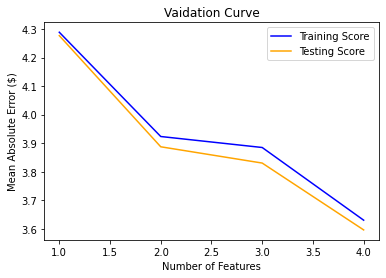

In [ ]:
training = []
testing = []
ks = range(1, len(X_train.columns)+1)

for k in ks:
  print(f'{k} features')

  selector = SelectKBest(k=k)
  X_train_selected = selector.fit_transform(X_train, y_train)
  X_test_selected = selector.transform(X_test)

  model = LinearRegression()
  model.fit(X_train_selected, y_train)
  y_pred_tr = model.predict(X_train_selected)
  MAE_tr = mean_absolute_error(y_train, y_pred_tr)
  training.append(MAE_tr)

  y_pred_te = model.predict(X_test_selected)
  MAE_te = mean_absolute_error(y_test, y_pred_te)
  testing.append(MAE_te)
  print(f'The testing data Mean Absolute Error is: {MAE_te:0.4f}\n')

# Plot showing the Mean Absolute Errors of training and testing data
plt.plot(ks, training, label="Training Score", color='blue')
plt.plot(ks, testing, label="Testing Score", color='orange')
plt.ylabel("Mean Absolute Error ($)")
plt.xlabel("Number of Features")
plt.title("Vaidation Curve")
plt.legend()
plt.show()

#### The results above shows that the Mean Absolute Error is lowest when all four features are used to run the model. So we will be using all four features to run our models.

#### Function to Run Models

In [ ]:
def model_compute(X_train, y_train, X_test, y_test, my_model):
  '''
  Input: Function takes X and y training and testing datasets and a model
  Computation: Function computes RMSE, MAE, and R-Square values
  Output: The output are print statements shwoinf the computed values
          for the training and testing datasets.
  '''
  model = my_model
  model.fit(X_train, y_train)

  # Predict on training data and compute metrics
  y_pred_train = model.predict(X_train)
  rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
  mae_train = mean_absolute_error(y_train, y_pred_train)
  r2_score_train = r2_score(y_train, y_pred_train)

  # Predict on test data and compute metrics
  y_pred = model.predict(X_test)
  rmse_test = np.sqrt(mean_squared_error(y_test, y_pred))
  mae_test = mean_absolute_error(y_test, y_pred)
  r2_score_test = r2_score(y_test, y_pred)
  print(my_model)
  print(" ")
  print("TRAINING DATA METRICS:")
  print("----------------------")
  print(f"The Root Mean Square Error (Training) is {rmse_train:0.4f}")
  print(f"The Mean Absolute Error (Training) is {mae_train:0.4f}")
  print(f"The R-Squared Value (Training) is {r2_score_train:0.4f}")
  print(" ")
  print("TESTING DATA METRICS:")
  print("---------------------")
  print(f"The Root Mean Square Error (Testing) is {rmse_test:0.4f}")
  print(f"The Mean Absolute Error (Testing) is {mae_test:0.4f}")
  print(f"The R-Squared Value (Testing) is {r2_score_test:0.4f}")
  print(" ")

#### Linear Regression Model

In [ ]:
# Uisng the model_compute function for Linear Regression
model_compute(X_train, y_train, X_test, y_test, LinearRegression())

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)
 
TRAINING DATA METRICS:
----------------------
The Root Mean Square Error (Training) is 4.5709
The Mean Absolute Error (Training) is 3.6300
The R-Squared Value (Training) is 0.9283
 
TESTING DATA METRICS:
---------------------
The Root Mean Square Error (Testing) is 4.5026
The Mean Absolute Error (Testing) is 3.5959
The R-Squared Value (Testing) is 0.9301
 


#### Linear Regression Model Testing Data Metrics

In [ ]:
# Testing Metrics from linear Regression model
lr_rmse = 4.5026
lr_mae = 3.5959 
lr_r2 = 0.9301

#### Random Forest Regressor Model

In [ ]:
# Using the model_compute function with Random Forest Regressor
model_compute(X_train, y_train, X_test, y_test, RandomForestRegressor(random_state=42))

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)
 
TRAINING DATA METRICS:
----------------------
The Root Mean Square Error (Training) is 1.2821
The Mean Absolute Error (Training) is 0.8902
The R-Squared Value (Training) is 0.9944
 
TESTING DATA METRICS:
---------------------
The Root Mean Square Error (Testing) is 3.2390
The Mean Absolute Error (Testing) is 2.3255
The R-Squared Value (Testing) is 0.9638
 


#### Random Forest Regressor Testing Metrics

In [ ]:
# Testing Metrics
rf_rmse = 3.2390
rf_mae = 2.3255 
rf_r2 = 0.9638

#### Gradient Boosting Regressor Model

In [ ]:
# model_compute with Gradient Boosting Regressor
model_compute(X_train, y_train, X_test, y_test, GradientBoostingRegressor(random_state=42))

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=42, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)
 
TRAINING DATA METRICS:
----------------------
The Root Mean Square Error (Training) is 3.7184
The Mean Absolute Error (Training) is 2.8217
The R-Squared Value (Training) is 0.9526
 
TESTING DATA METRICS:
---------------------
The Root Mean Square Error (Testing) is 3.8287
The Mean Absolute Error (Testing) is 2.9487
The R-Squared Val

#### Gradient Boosting Regressor Model Testing Metrics

In [ ]:
# Testing Metrics
gb_rmse = 3.8287
gb_mae = 2.9487 
gb_r2 = 0.9495

# Tune Model with lowest Mean Absolute Error - Random Forest Regressor

> The Random Forest Regressor has the lowest test Mean Absolute Error value of the four models tested. I will be doing a two tiered grid search to tune the Random Forest Regressor Model. After the tier 1 search, the best parameters will be selected and used to do a second tier search to fine tune the model to check if the Mean Absolute Error and/or the R-Sqaured can be improved.

#### Tuning The Random Forest Regressor Model using GridSearchCV 

In [ ]:
# param_dict = {
#     "n_estimators": range(50, 251, 50),
#     "criterion": ["mse","mae"],
#     "max_depth": range(2, 23, 2),
#     "min_samples_split": range(2, 7, 2),
#     "min_samples_leaf": range(1, 5, 1)
# }

In [ ]:
# model_rfr = GridSearchCV(
#     RandomForestRegressor(),
#     param_grid = param_dict,
#     cv=5,
#     verbose=1,
#     n_jobs=-1
# )

# model_rfr.fit(X_train, y_train)

> A full blown Grid Search was ran to tune the hyperparameters of the Random Forest Regressor with the parameters shown in the above two cells **Fitting 5 folds for each of 1320 candidates, totalling 6600 fits** The best parameters from this search criterion= 'mse', max_dept=22, and n_estimators = 250. I used these Grid Search values to run a a new Random Forest Regressor, then I used the new model in the model_compute function to calculate the model metrics.

In [ ]:
# I used only criterion, max_depth and n_estimators from the Grid search
# Other parameters were default values and were left out.
rfgs_model = RandomForestRegressor(criterion='mse',
                                    max_depth=22,n_estimators=250,
                                    random_state=42)
rfgs_model.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=22, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=250, n_jobs=None, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

In [ ]:
# model_compute function with random forest regressor model - rfgs_model
model_compute(X_train, y_train, X_test, y_test, rfgs_model)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=22, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=250, n_jobs=None, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)
 
TRAINING DATA METRICS:
----------------------
The Root Mean Square Error (Training) is 1.2585
The Mean Absolute Error (Training) is 0.8805
The R-Squared Value (Training) is 0.9946
 
TESTING DATA METRICS:
---------------------
The Root Mean Square Error (Testing) is 3.2244
The Mean Absolute Error (Testing) is 2.3105
The R-Squared Value (Testing) is 0.9642
 


#### Random Forest Regressor Model Testing Metrics - Regular

In [ ]:
# Testing Metrics
rfgs_rmse = 3.2244
rfgs_mae = 2.3105 
rfgs_r2 = 0.9642

# Communication of Results
#### Create a Dataframe of shwoing result of metrics

In [ ]:
data = {
    'Model': ['Logistic Regression', 'Random Forest Regressor',
              'Gradient Boosting Regressor','Tuned Random Forest Regressor'],
        'RMSE': [lr_rmse, rf_rmse, gb_rmse, rfgs_rmse],
        'MAE': [lr_mae, rf_mae, gb_mae, rfgs_mae],
        'R-Square': [lr_r2, rf_r2, gb_r2, rfgs_r2]
}

results = pd.DataFrame(data).set_index('Model')
results

,RMSE,MAE,R-Square
Model,,,
Logistic Regression,4.5026,3.5959,0.9301
Random Forest Regressor,3.2390,2.3255,0.9638
Gradient Boosting Regressor,3.8287,2.9487,0.9495
Tuned Random Forest Regressor,3.2244,2.3105,0.9642


> The Tuned Random Forest Regressor had the bestscores across all three metrics of model validation.

#### Permutation Importance

In [ ]:
perm_imp = permutation_importance(rfgs_model,
                                  X_test, 
                                  y_test, 
                                  n_jobs=-1, 
                                  random_state=42)

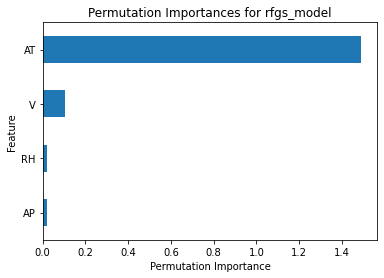

In [ ]:
perm_imp['importances_mean']
data = pd.DataFrame({'importances_mean': perm_imp['importances_mean']}, index = X_test.columns)

data['importances_mean'].sort_values().tail().plot(kind='barh')
plt.xlabel('Permutation Importance')
plt.ylabel('Feature')
plt.title('Permutation Importances for rfgs_model');

> As shown in the chart above, and not surprisingly, permutations of the Ambient Temperature has the biggest effect on the performance of the model, Exhaust Vacuum (V) has the next biggest permuation effect on the model performance, although its effect is significantly smaller than the Ambient Temperature's. Relative Humidity and Ambient Pressure both had near negligible effect on model performance upon permutation of the cell values for each of the features.

#### Partial Dependence Plots (PDP)

#### PDP for Ambient Temperature

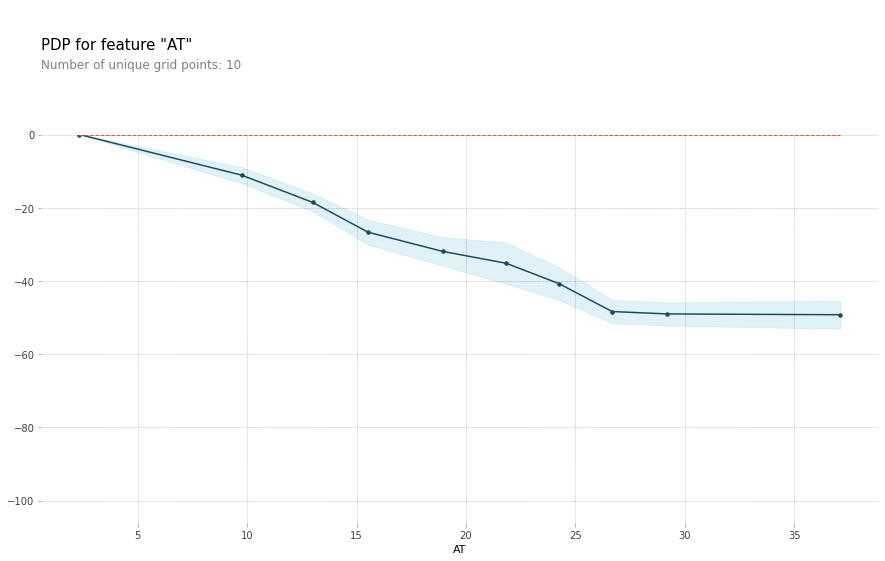

In [ ]:
feature = 'AT'
isolate = pdp_isolate(
          model=rfgs_model,
          dataset=X_test,
          model_features=X_test.columns,
          feature=feature
)

pdp_plot(isolate, feature_name=feature);

#### PDP for Exhaust Vacuum

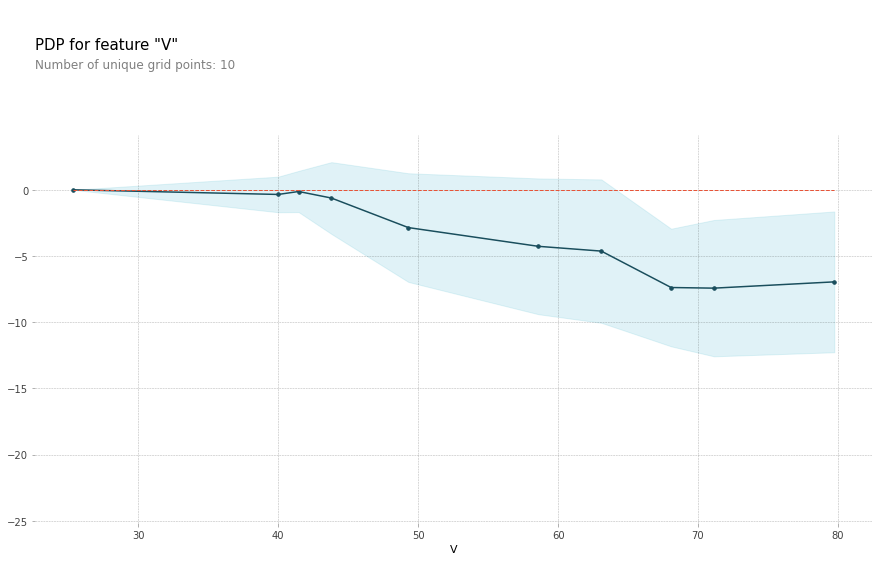

In [ ]:
feature = 'V'
isolate = pdp_isolate(
          model=rfgs_model,
          dataset=X_test,
          model_features=X_test.columns,
          feature=feature
)

pdp_plot(isolate, feature_name=feature);

#### PDP with Ambient Temperature (AT) and Exhaust Vacuum (V)

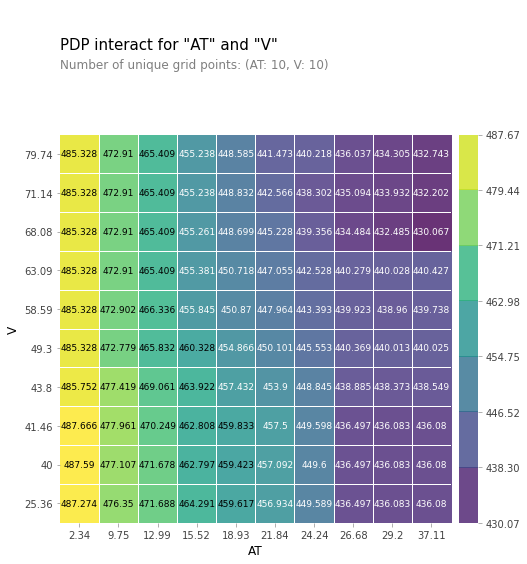

In [ ]:
feature = ['AT','V']
interact = pdp_interact(
    model = rfgs_model,
    dataset = X_test,
    model_features = X_test.columns,
    features = feature
)

pdp_interact_plot(interact, plot_type='grid', feature_names=feature);

#### Shapely Plots of observations with selected Temperatures 

In [ ]:
# First observation is the row where temperature is 37.11 Degree Celsius
t=37.11
obs_1 = X_test[X_test.AT== t]
print(f"Power Output when temp is {t} Deg C is {rfgs_model.predict(obs_1)[0]:0.2f} Megawatts")
obs_1

Power Output when temp is 37.11 Deg C is 430.28 Megawatts


,AT,V,AP,RH
5349,37.11,68.94,1006.23,31.15


In [ ]:
explainer = TreeExplainer(rfgs_model)

initjs()

force_plot(
    base_value=explainer.expected_value,
    shap_values=explainer.shap_values(obs_1),
    features=obs_1
)

In [ ]:
# Second observation at temperature = 18.93
t= 18.93
obs_2 = X_test[X_test.AT== t]
print(f"Power Output when temp is {t} Deg C is {rfgs_model.predict(obs_1)[0]:0.2f} Megawatts")
obs_2

Power Output when temp is 18.93 Deg C is 430.28 Megawatts


,AT,V,AP,RH
9426,18.93,67.71,1005.04,82.4


In [ ]:
explainer = TreeExplainer(rfgs_model)

initjs()

force_plot(
    base_value=explainer.expected_value,
    shap_values=explainer.shap_values(obs_2),
    features=obs_2
)

In [ ]:
# Third observation is the row where temperature is 2.34 Degree Celsius
t = 2.34
obs_3 = X_test[X_test.AT== t]
print(f"Power Output when temp is {t} Deg C is {rfgs_model.predict(obs_1)[0]:0.2f} Megawatts")
obs_3

Power Output when temp is 2.34 Deg C is 430.28 Megawatts


,AT,V,AP,RH
8400,2.34,39.42,1028.47,69.68


In [ ]:
explainer = TreeExplainer(rfgs_model)

initjs()

force_plot(
    base_value=explainer.expected_value,
    shap_values=explainer.shap_values(obs_3),
    features=obs_3
)